In [11]:
'''
This script is to decode the generated latent embedding of multi-condition data and evaluate them
Be careful to change all the path that appear to your own
'''

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
import celltypist
import seaborn as sns  
from statannotations.Annotator import Annotator

In [4]:
def load_VAE():
    autoencoder = VAE(
        num_genes=14652,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_ood_scimilarity_lognorm_finetune/model_seed=0_step=150000.pt'))
    return autoencoder

real data

In [5]:
# real data in h5ad format
adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/mam_spl_T_B.h5ad')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()

gene_names = adata.var_names
cellclass = adata.obs['celltype']
organtype = adata.obs['organ']
celltype = [cellclass[i]+'_'+organtype[i] for i in range(len(cellclass))]
adata.obs['cellinfo'] = celltype

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

cell_data = adata.X.toarray()

cell_data.shape

(11330, 14652)

generated data

In [6]:
cell_gen_all = []
gen_class = []

cato = ['mam_B', 'mam_T', 'spl_T', 'spl_B']
type = ['B cell', 'T cell']
organ = ['mammary', 'spleen']
nums = [0]

autoencoder = load_VAE()
count = 0
# generated mammary data, mammary B cells and mammary T cells
for i in range(2):
    for j in [0]:
        npzfile=np.load(f'/data1/lep/Workspace/guided-diffusion/output/ood_muris/muris_filted_{i}_{j}_scimilarity2.npz',allow_pickle=True)
        num = 1000
        cell_gen_all.append(npzfile['cell_gen'][:num])
        gen_class += ['gen_'+type[i]+'_'+organ[j]] * num
        count+=num
        nums.append(count)

cell_gen_all = np.concatenate(cell_gen_all)
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).detach().cpu().numpy()
adata_gen = ad.AnnData(cell_gen_all)
adata_gen.obs['celltype'] = gen_class


ori = ad.AnnData(cell_gen_all, dtype=np.float32)#[::2]

ori.obs['celltype'] = gen_class#[::2]
ori.var_names = gene_names

cell_gen = ori.X

cell_gen.shape

(2000, 14652)

marker gene significance test

In [10]:
adata_tmp = adata[adata.obs['organ']=='mammary']
real_cell = adata_tmp[adata_tmp.obs['cellinfo']=='B cell_mammary'].X.toarray()
other_cell = adata_tmp[adata_tmp.obs['cellinfo']!='B cell_mammary'].X.toarray()
sample_size = min(real_cell.shape[0],other_cell.shape[0])
real_cell, other_cell = real_cell[:sample_size], other_cell[:sample_size]
gen_cell = ori[ori.obs['celltype']=='gen_B cell_mammary'].X[:sample_size]
cell_type = ['2_real']*real_cell.shape[0]+['1_other']*other_cell.shape[0]+['3_generated']*gen_cell.shape[0]
all_cell = np.concatenate((real_cell,other_cell,gen_cell),axis=0)
adata_new = ad.AnnData(all_cell)
adata_new.var_names = gene_names
adata_new.obs['cell_type'] = cell_type

In [11]:
gene_name = 'Cd74' #'Cd79a'
data = {'group':adata_new.obs['cell_type'],
        gene_name :adata_new[:,gene_name].X.toarray().squeeze(-1)}
df = pd.DataFrame(data)

1_other vs. 2_real: Wilcoxon test (paired samples), P_val:2.076e-127 Stat=5.550e+02
1_other vs. 3_generated: Wilcoxon test (paired samples), P_val:7.056e-129 Stat=7.000e+01


(<Axes: xlabel='group', ylabel='Cd74'>,
  <statannotations.Annotation.Annotation at 0x7fe0780243a0>])

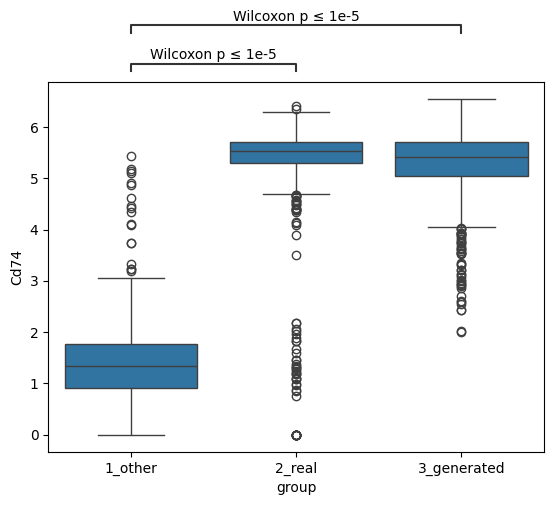

In [12]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

x = "group"
y = gene_name
order = ['1_other', '2_real', '3_generated']

ax = sns.boxplot(data=df, x=x, y=y, order=order)

pairs=[('1_other', '2_real'), ('1_other', '3_generated')]

annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
annotator.configure(test='Wilcoxon', text_format='simple', loc='outside')
annotator.apply_and_annotate()
# plt.savefig(f'../figure_pdf_new/{gene_name}_boxplot.pdf', dpi=300, bbox_inches='tight')

celltypist test

In [13]:
mam_B = ori[ori.obs['celltype']=='gen_B cell_mammary'].copy()

predictions = celltypist.annotate(mam_B, model = '/data1/lep/Workspace/guided-diffusion/checkpoint_old/celltypist_muris_mam_re.pkl')
print((predictions.predicted_labels.squeeze(1).values == 'B cell').sum()/mam_B.X.shape[0])

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1000 cells and 14652 genes
🔗 Matching reference genes in the model
🧬 14228 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


0.989


In [15]:
testset = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/testset_muris_mam.h5ad')
testset = testset[testset.obs['celltype']=='B cell']
predictions = celltypist.annotate(testset, model = '/data1/lep/Workspace/guided-diffusion/checkpoint_old/celltypist_muris_mam_re.pkl')
print((predictions.predicted_labels.squeeze(1).values == 'B cell').sum()/testset.X.shape[0])

🔬 Input data has 127 cells and 15818 genes
🔗 Matching reference genes in the model
🧬 15776 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


0.9133858267716536
